In [1]:
import pandas as pd
import gzip
import json

You can download the data from here(Make sure you download only Pet Supplies data).  https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/

In [2]:
def load_data(file_name, head = None):
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)
            
            # break if reaches the 100th line
            if (head is not None) and (count > head):
                break
    return data

In [3]:
df_meta = pd.DataFrame(load_data(r"data\meta_Pet_Supplies.json.gz"))

In [4]:
df_review = pd.DataFrame(load_data(r"data\Pet_Supplies.json.gz"))

In [5]:
df_meta.category.explode().value_counts()[:10]

Pet Supplies                    189493
Dogs                            118176
Collars, Harnesses & Leashes     31083
Cats                             28383
Fish & Aquatic Pets              19061
Apparel & Accessories            17977
Toys                             17694
Collars                          15321
Treats                           15091
Food                             14196
Name: category, dtype: int64

In [6]:
df_meta.loc[lambda x: x.asin == "B000W5QSYA"]

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
30741,"[Pet Supplies, Dogs, Food, Dry]",,"[, Modern science proves that your dog shares ...",,Taste Of The Wild Grain Free High Protein Dry ...,"[B0043RWAVI, B000W5U5H6, B0097ETPRY, B0018CE6Z...",,Taste of the Wild,[A Taste Of The Wild With Roasted Quail; Real ...,"10,535 in Pet Supplies (","[B000W5U5H6, B0018CE6ZE, B0043RWAVI, B0097ETPR...",Pet Supplies,"class=""a-bordered a-horizontal-stripes a-spa...",,,B000W5QSYA,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{' Product Dimensions: ': '4 x 14 x 1...


In [7]:
df_meta.loc[lambda x: x.brand == "Taste of the Wild"].asin.nunique()

26

In [8]:
df_meta.loc[lambda x: x.brand == "Taste of the Wild"].explode("category").category.value_counts()

Pet Supplies              25
Food                      23
Dogs                      15
Dry                       13
Wet                       10
Canned                    10
Cats                       8
Pet Content - Main         2
Pet Content - Dog Main     2
Dog Food                   2
Name: category, dtype: int64

In [9]:
(
    df_meta
    .explode("category")
    .loc[
    lambda x: 
        (x.brand == "Taste of the Wild") &
        (x.category.isin(["Food"]))
    ]).title.unique()

array(['Taste Of The Wild Grain Free High Protein Dry Dog Food Wetlands - Roasted Duck',
       'Taste of the Wild Grain Free High Protein Real Meat Recipe Premium Dry Cat Food',
       'Taste of the Wild Grain Free Real Meat Recipe Premium Wet Canned Stew Dog Food',
       'Taste Of The Wild Fowl Dog Food, 13.2-Ounce',
       'Taste of the Wild Rocky Mountain Cat Food (5 lb)',
       'Taste of the Wild Grain Free Real Meat Recipe Premium Wet Canned Stew Cat Food',
       'Taste of the Wild Sierra Mountain Dog Food 15lb',
       'Taste of the Wild Sierra - 5 lbs',
       'Taste of the Wild Canyon River Can Cat, 24/3 Oz',
       'Taste Of The Wild High Prairie Can Dog Food,13.2 Oz',
       'Taste of the Wild Rocky Mountain Feline Formula, 5 Pounds',
       'Taste of the Wild Dry Dog Food, Hi Prairie Canine Formula with Roasted Bison &amp; Venison, 30-Pound Bag (jumbo pack 60 pound)',
       'Taste Of The Wild Wetlands Dry Dog Food',
       'Taste of the Wild Dry Dog Food, Hi Prairie Can

In [10]:
totw_dog_food_asin = (
    df_meta
    .explode("category")
    .loc[
    lambda x: 
        (x.brand == "Taste of the Wild") &
        (x.category.isin(["Food"]))
    ]
).asin.unique()

In [11]:
dog_food_asin = (
    df_meta
    .explode("category")
    .loc[
    lambda x: 
        (x.category.isin(["Dogs","Cats","Food"]))
    ]
).asin.unique()

In [12]:
df_review.loc[lambda x: x.asin.isin(dog_food_asin)].shape

(5546509, 12)

In [13]:
df_review.loc[lambda x: x.asin.isin(totw_dog_food_asin)].shape

(36800, 12)

<Axes: ylabel='Frequency'>

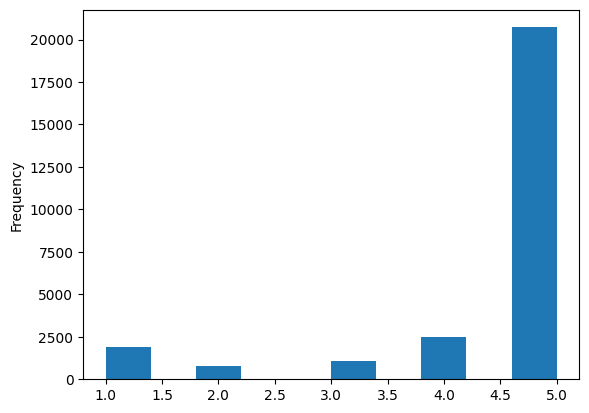

In [14]:
df_review.loc[lambda x: x.asin == "B000W5QSYA"].overall.plot(kind="hist")

----------------------------------------------------------------------------------------------------------------------

## Prepare Data

In [15]:
df_totw = df_review.loc[lambda x: (x.asin.isin(totw_dog_food_asin)) & (~x.reviewText.isna())]

In [16]:
from joblib import Parallel, delayed

import nltk
from nltk.corpus import stopwords
import string

# Load the stopwords
STOP_WORDS = set(stopwords.words('english'))

In [17]:
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = ''.join(word for word in text if not word.isdigit())
    # Tokenize text
    tokens = nltk.word_tokenize(text.lower())
    # Remove stop words
    tokens = [token for token in tokens if token not in STOP_WORDS]
    # Rejoin tokens into a string
    text = ' '.join(tokens)
    return text

def pre_process_column(df:pd.DataFrame) -> pd.DataFrame:
    assert "reviewText" in df.columns
    df = df.assign(
        preprocessed_text = Parallel(n_jobs=8)(delayed(preprocess_text)(text) for text in df.reviewText)
        )
    return df

In [18]:
df_totw = pre_process_column(df_totw)

In [19]:
df_totw.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image,preprocessed_text
1404950,5.0,22,False,"01 12, 2009",A3GBY9HEHC767B,B000W5QSYA,Lori A. Witkop,After trying MANY other foods I finally found ...,"DOG TESTED, MOTHER APPROVED!!!!!!!",1231718400,NaN,NaN,trying many foods finally found one ive found ...
1404951,5.0,37,False,"10 7, 2008",A2VMFC3QRZFPYC,B000W5QSYA,Mrs. O,I couldn't understand why one of my dogs had a...,"Finally, a high protein dog food my dogs love.",1223337600,NaN,NaN,couldnt understand one dogs almost daily diahe...
1404952,5.0,3,False,"07 30, 2008",A3STUI3SPCT1KC,B000W5QSYA,R. Ferrell,I have had a terrible time finding a dry dog f...,My boston terriers love this!,1217376000,"{'Size:': ' 30lb', 'Flavor Name:': ' Wetlands ...",NaN,terrible time finding dry dog food boston terr...
1404953,5.0,18,False,"06 25, 2008",ANSA83I0WOUR2,B000W5QSYA,Claudia,I've been very happy with Taste of the Wild ev...,Great food,1214352000,"{'Size:': ' 30lb', 'Flavor Name:': ' Wetlands ...",NaN,ive happy taste wild ever since switching dog ...
1405003,5.0,NaN,True,"05 21, 2018",A3C6DMUE0IEL4H,B000W5QSYA,Reese Brown,I went from a food with grains and crap to thi...,I went from a food with grains and crap to this,1526860800,"{'Size:': ' 30lb', 'Flavor Name:': ' High Prai...",NaN,went food grains crap dog recent hip problems ...


## Modelling

In [29]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier


from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from pprint import pprint
from time import time
import logging

In [21]:
sns.set_theme("notebook")

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df_totw, df_totw.overall, \
                                                                       test_size=0.33, random_state=42)

In [23]:
vectorizer = TfidfVectorizer(smooth_idf=False,
                             ngram_range = (1,4)
                             )

In [81]:
X_train_vec = vectorizer.fit_transform(X_train.preprocessed_text)
X_test_vec = vectorizer.transform(X_test.preprocessed_text)

In [82]:
def gridSearch(pipeline,parameters,CV=3,score=None,jobs=-1):
    if __name__ == "__main__":

        grid_search = GridSearchCV(pipeline, parameters, n_jobs=jobs, verbose=1,cv=CV,scoring=score)

        print("Performing grid search...")
        print("pipeline:", [name for name, _ in pipeline.steps])
        print("parameters:")
        pprint(parameters)
        t0 = time()
        grid_search.fit(X_train_vec,  y_train)
        print("done in %0.3fs" % (time() - t0))
        print()

        print("Best score: %0.3f" % grid_search.best_score_)
        print("Best parameters set:")
        best_parameters = grid_search.best_estimator_.get_params()
        for param_name in sorted(parameters.keys()):
            print("\t%s: %r" % (param_name, best_parameters[param_name]))
        return grid_search

In [83]:
pipeline_pac= Pipeline([
         ('pac',PassiveAggressiveClassifier())
])
parameters_pac = { 'pac__C': (1,2,5,10)}

In [84]:
pac_grid = gridSearch(pipeline_pac,parameters_pac,CV=10,score='f1_macro')

Performing grid search...
pipeline: ['pac']
parameters:
{'pac__C': (1, 2, 5, 10)}
Fitting 10 folds for each of 4 candidates, totalling 40 fits
done in 16.701s

Best score: 0.827
Best parameters set:
	pac__C: 1


In [85]:
y_pred = pac_grid.best_estimator_.predict(X_test_vec)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.86      0.92      0.89       904
         2.0       0.91      0.68      0.78       416
         3.0       0.88      0.78      0.83       539
         4.0       0.91      0.69      0.78      1151
         5.0       0.95      0.99      0.97      9130

    accuracy                           0.94     12140
   macro avg       0.90      0.81      0.85     12140
weighted avg       0.93      0.94      0.93     12140



In [86]:
import operator
def vis_df(grid):    
    df = pd.DataFrame(grid.cv_results_)
    idVars = df.filter(regex=("param_*")).drop("params",axis=1).columns.values
    valueVars = df.filter(regex=("split*")).columns.values
    df = pd.melt(df, id_vars=idVars,value_vars=list(valueVars))
    df.loc[:,("split")] = df.variable.apply(lambda x: x.split('_')[0])
    df.loc[:,("validation")] = df.variable.apply(lambda x: x.split('_')[1])
    for col in df.filter(regex="param*").columns:
        df.loc[:,col] = df.loc[:,col].apply(lambda x: str(sorted(x.items(), key=operator.itemgetter(0))) \
                                            if type(x) is dict else str(x)  )
    return df.drop("variable",axis=1).rename(columns={'value':'score'})

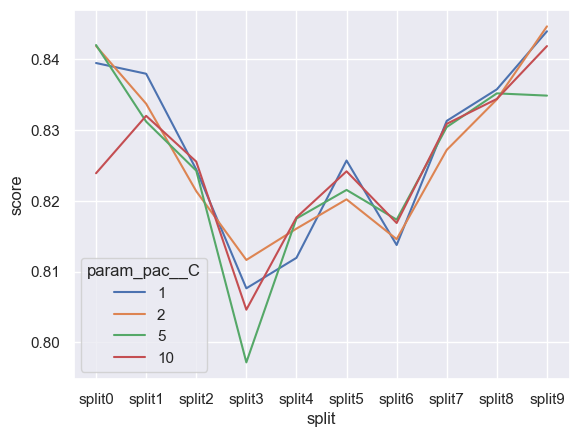

In [87]:
g = sns.lineplot(x="split", y="score",hue="param_pac__C",  data=vis_df(pac_grid))

In [88]:
pipeline_svd = Pipeline([
         ('svd',SGDClassifier(warm_start = True))
])

parameters_svd = {'svd__penalty': ('l2', 'l1'),
                  'svd__loss': ('hinge','log')
    
}

In [89]:
svd_grid = gridSearch(pipeline_svd,parameters_svd,CV=2,score='f1_macro')

Performing grid search...
pipeline: ['svd']
parameters:
{'svd__loss': ('hinge', 'log'), 'svd__penalty': ('l2', 'l1')}
Fitting 2 folds for each of 4 candidates, totalling 8 fits
done in 3.721s

Best score: 0.630
Best parameters set:
	svd__loss: 'hinge'
	svd__penalty: 'l2'


In [90]:
y_pred = svd_grid.best_estimator_.predict(X_test_vec)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.86      0.74      0.80       904
         2.0       0.94      0.32      0.47       416
         3.0       0.88      0.35      0.50       539
         4.0       0.94      0.16      0.28      1151
         5.0       0.84      1.00      0.91      9130

    accuracy                           0.85     12140
   macro avg       0.89      0.51      0.59     12140
weighted avg       0.86      0.85      0.81     12140



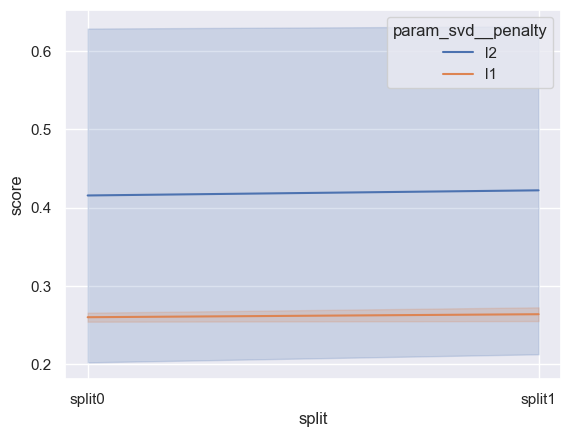

In [91]:
g = sns.lineplot(x="split", y="score",hue="param_svd__penalty",  data=vis_df(svd_grid))

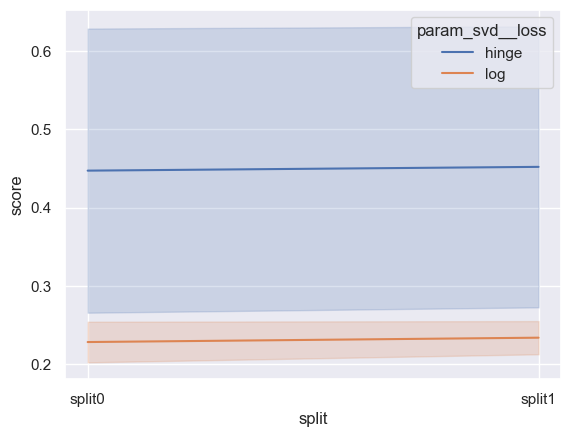

In [92]:
g = sns.lineplot(x="split", y="score",hue="param_svd__loss",  data=vis_df(svd_grid))

In [93]:
pipeline_nb = Pipeline([
         ('NB', MultinomialNB())
])

parameters_nb = {'NB__alpha':(0.01,.1,1,10)}

In [94]:
nb_grid = gridSearch(pipeline_nb,parameters_nb,CV=10,score='f1_weighted')

Performing grid search...
pipeline: ['NB']
parameters:
{'NB__alpha': (0.01, 0.1, 1, 10)}
Fitting 10 folds for each of 4 candidates, totalling 40 fits
done in 3.035s

Best score: 0.875
Best parameters set:
	NB__alpha: 0.1


In [95]:
y_pred = nb_grid.best_estimator_.predict(X_test_vec)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.98      0.75      0.85       904
         2.0       1.00      0.64      0.78       416
         3.0       0.97      0.69      0.81       539
         4.0       0.97      0.62      0.75      1151
         5.0       0.90      1.00      0.95      9130

    accuracy                           0.92     12140
   macro avg       0.96      0.74      0.83     12140
weighted avg       0.92      0.92      0.91     12140



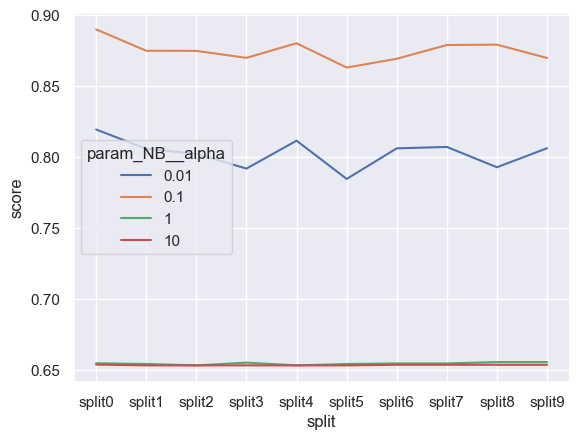

In [96]:
g = sns.lineplot(x="split", y="score",hue="param_NB__alpha",  data=vis_df(nb_grid))

In [97]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [132]:
y_pred = pac_grid.best_estimator_.predict(X_test_vec)
cm = confusion_matrix(y_test, y_pred, labels=pac_grid.best_estimator_.classes_)

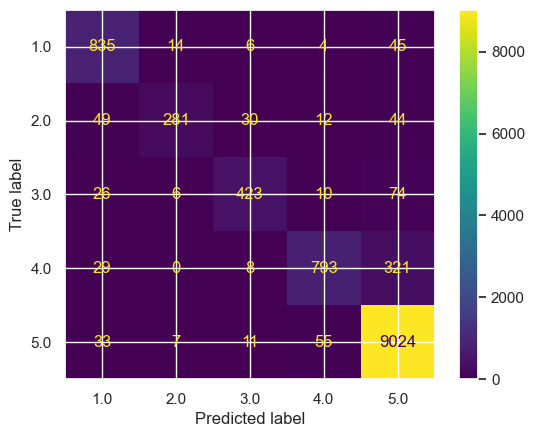

In [133]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=pac_grid.best_estimator_.classes_)
disp.plot()
plt.show()

In [129]:
pac = PassiveAggressiveClassifier(C=1.0)
pac.fit(X_train_vec,  y_train)

PassiveAggressiveClassifier()

In [130]:
feature_names = vectorizer.get_feature_names_out()
sorted(zip(pac.coef_[0], feature_names),reverse=True)[:20]

[(5.269984010530528, 'diarrhea'),
 (4.951572114334404, 'sick'),
 (2.66661633080196, 'doesnt like'),
 (2.635027516599219, 'throwing'),
 (2.5923590337946125, 'threw'),
 (2.5477958162385668, 'bag'),
 (2.523997987828409, 'reviews'),
 (2.430354958833348, 'away'),
 (2.42279121302591, 'vomiting'),
 (2.13113886016259, 'beware'),
 (2.080463028521524, 'good bulldogs'),
 (2.047215983378896, 'loved food shipping'),
 (2.033608677300414, 'ill'),
 (1.9988366967537041, 'dog care'),
 (1.9488695994942882, 'cat eat'),
 (1.910154300973196, 'blood'),
 (1.9024669155974312, 'refund'),
 (1.901648214576637, 'amazon'),
 (1.885680334928968, 'disappointed'),
 (1.8429675891630724, 'recent')]

In [134]:
feature_names = vectorizer.get_feature_names_out()
sorted(zip(pac.coef_[1], feature_names),reverse=True)[:20]

[(2.243752495731569, 'hated'),
 (2.070815751826196, 'dog food allergies'),
 (1.984833512794431, 'puppy doesnt like flavor'),
 (1.9051407464970764, 'shh'),
 (1.7504224481435895, 'doesnt like flavor'),
 (1.5981941137327986, 'cat nibbles'),
 (1.547883714735202, 'smells terrible'),
 (1.5446150649566255, 'fillers thought'),
 (1.493585518346686, 'cat doesnt really like'),
 (1.475976936088188, 'puppy wont eat'),
 (1.4579915430979027, 'dog dont like'),
 (1.4471363660629863, 'canola'),
 (1.4403455255666748, 'puppy wont'),
 (1.4328147723840665, 'dogs like food'),
 (1.4032969471458117, 'touch'),
 (1.372055905256065, 'cat doesnt really'),
 (1.3321350145756365, 'dog didnt love'),
 (1.3158186765536408, 'gave dog bad gas'),
 (1.2919110510453526, 'dogs seen like'),
 (1.2919110510453526, 'dogs seen')]

In [135]:
feature_names = vectorizer.get_feature_names_out()
sorted(zip(pac.coef_[2], feature_names),reverse=True)[:20]

[(2.002813265818828, 'really like much'),
 (2.002813265818828, 'didnt really like much'),
 (1.9592299005681335, 'really care taste'),
 (1.863277391193464, 'adequate'),
 (1.848310604259209, 'meh'),
 (1.8422670904405754, 'liked ok'),
 (1.8422670904405754, 'dog liked ok'),
 (1.8252954406185795, 'care taste'),
 (1.8107346669200863, 'good enough'),
 (1.7107085292148192, 'unfortunately'),
 (1.6722178698479773, 'didnt really care taste'),
 (1.6563560802032964, 'cats crazy'),
 (1.5657325208400013, 'dog allergic something'),
 (1.5557053565686483, 'didnt'),
 (1.5392310806730898, 'sure'),
 (1.4816595110511284, 'like'),
 (1.476173533385754, 'im sure'),
 (1.4639929888180752, 'hole bag'),
 (1.4502048408453607, 'allergic something'),
 (1.4166603444007393, 'still alergies')]

In [136]:
feature_names = vectorizer.get_feature_names_out()
sorted(zip(pac.coef_[3], feature_names),reverse=True)[:20]

[(3.3971207550032774, 'gsd loves food'),
 (3.114156706883684, 'likes'),
 (3.087074496998761, 'cat likes food'),
 (3.00104908957498, 'pup likes like'),
 (2.8154051560239544, 'excellent love'),
 (2.743167007817646, 'dogs love taste wild'),
 (2.725027029897814, 'though'),
 (2.5853491215249256, 'good food dogs liked'),
 (2.5743961458584783, 'dogs happy'),
 (2.426376112140239, 'great order'),
 (2.4219902069233448, 'favorite dog'),
 (2.367782656364128, 'cats happy'),
 (2.3667350338696047, 'good good'),
 (2.338584041638977, 'food great price great'),
 (2.31743262965144, 'say dogs like'),
 (2.3052007514172472, 'bulldog love'),
 (2.27411145295604, 'happy dog'),
 (2.250234374456014, 'picky dog likes'),
 (2.207450784021371, 'seem like healthy'),
 (2.207450784021371, 'cats seem like healthy')]

In [137]:
feature_names = vectorizer.get_feature_names_out()
sorted(zip(pac.coef_[4], feature_names),reverse=True)[120:140]

[(1.2591200835901046, 'beat'),
 (1.2518853834118968, 'solid'),
 (1.2482373934534379, 'brands'),
 (1.247588448552602, 'great food dogs liked'),
 (1.2460839109177182, 'helped'),
 (1.2436617084045272, 'good food good'),
 (1.2314847841986776, 'dog love'),
 (1.2268123279152257, 'pounds'),
 (1.2252035738205158, 'dogs seem enjoy brand'),
 (1.2229759216122253, 'seem enjoy brand'),
 (1.2225060523633295, 'product good price'),
 (1.2190634180263347, 'lb'),
 (1.2115985667806073, 'enjoyed cats'),
 (1.2089743949945881, 'really good'),
 (1.2027679842021946, 'food much'),
 (1.2021714680289723, 'dog seems'),
 (1.2010730470455049, 'well food'),
 (1.1954408898187825, 'dog likes doesnt like'),
 (1.1895191970148833, 'time ok'),
 (1.1873198032879106, 'good ingredients')]

In [138]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [32]:
df_gas = df_totw.loc[lambda x: (x.preprocessed_text.str.contains("gas"))]

In [140]:
def get_aspect(text):
  aspects = []
  doc1 = nlp(text.lower())
  for sentence in doc1.sents:
    doc = nlp(sentence.text)
    descriptive_term = ''
    target = ''
    for token in doc:
      if token.dep_ == 'nsubj' and token.pos_ == 'NOUN':
        target = token.text
      if token.pos_ == 'ADJ':
        prepend = ''
        for child in token.children:
          if child.pos_ != 'ADV':
            continue
          prepend += child.text + ' '
        descriptive_term = prepend + token.text
    if len(target) > 0 and len(descriptive_term)>0:
      aspects.append({'aspect': target, 'description': descriptive_term})
  return aspects

In [141]:
text = 'I like the ingredients in this brand. before I used to feed them purina one true Instinct and my little Maltese mix would pick out all these soft bites. These are all round pellets so there is no picking for her to do which is awesome. The only downside is that my French Bulldog gets extremely gassy eating this brand'
get_aspect(text)

[{'aspect': 'bulldog', 'description': 'extremely gassy'}]

In [29]:
text = "Our dogs love this flavor but we love this brand. They aren't gassy, their coats are nice and shiny and their breath doesn't stink."
get_aspect(text)

[{'aspect': 'breath', 'description': 'shiny'}]

In [30]:
text = 'After trying a few different brands of grain-free food for my dogs, I gave up and settled on Canidae as my Doberman couldn\'t seem to handle the other premium foods.  Recently, however, I decided to give Taste of the Wild High Prairie formula a try.  I mixed it with the Canidae for about a week and then converted him over completely to Taste of the Wild.  He never had any digestive issues and within a couple of weeks his coat looked brighter.  Strangely, after all of the gastrointestinal problems he had in previous attempts to convert to grain-free, his "bathroom" activity actually improved.  I couldn\'t be happier with the product.  Oh, by the way, both of my dogs love the food as well.'
get_aspect(text)

[{'aspect': 'doberman', 'description': 'other'},
 {'aspect': 'coat', 'description': 'brighter'},
 {'aspect': 'activity', 'description': 'free'}]

In [32]:
text = "We've ordered this dog food 6 times from AMZN, with the first 4 times (chicken/turkey) we had no issues, and our dog really liked it.  The time before last, we ordered the Bison/Venison and our dog didn't want to eat it and it seemed to upset her stomach a bit, so we went back and ordered the chicken/turkey.  This time, our dog seemed to smell something was off, as she almost refused to eat it, but we kept it out and she eventually ate it, and it was not pleasant.  Her stomach was gurgling, had bad gas and liquid stool.  At first, we thought she had a bug, but after a week we switched to dog food from a local pet store and within 24 hours her stomach seemed to be back to normal.  Others have reported a hit and miss with AMZN dog food, and I can attest we have now experienced that as well."
get_aspect(text)

[{'aspect': 'dog', 'description': 'first'},
 {'aspect': 'venison', 'description': 'last'},
 {'aspect': 'dog', 'description': 'pleasant'},
 {'aspect': 'stomach', 'description': 'liquid'},
 {'aspect': 'stomach', 'description': 'normal'},
 {'aspect': 'others', 'description': 'amzn'}]

In [13]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [28]:
sentences = [
  'The only downside is that my French Bulldog gets extremely gassy eating this brand'
]
for sentence in sentences:
  doc = nlp(sentence)
  for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,token.pos_,[child for child in token.children])

The det downside NOUN DET []
only amod downside NOUN ADJ []
downside nsubj is AUX NOUN [The, only]
is ROOT is AUX AUX [downside, gets]
that mark gets VERB SCONJ []
my poss Bulldog PROPN PRON []
French compound Bulldog PROPN ADJ []
Bulldog nsubj gets VERB PROPN [my, French]
gets ccomp is AUX VERB [that, Bulldog, gassy, eating]
extremely advmod gassy ADJ ADV []
gassy acomp gets VERB ADJ [extremely]
eating advcl gets VERB VERB [brand]
this det brand NOUN DET []
brand dobj eating VERB NOUN [this]


In [30]:
sentences = [
  "They aren't gassy, their coats are nice and shiny and their breath doesn't stink."
]
for sentence in sentences:
  doc = nlp(sentence)
  for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,token.pos_,[child for child in token.children])

They nsubj are AUX PRON []
are ccomp are AUX AUX [They, n't, gassy]
n't neg are AUX PART []
gassy acomp are AUX ADJ []
, punct are AUX PUNCT []
their poss coats NOUN PRON []
coats nsubj are AUX NOUN [their]
are ROOT are AUX AUX [are, ,, coats, nice, and, stink]
nice acomp are AUX ADJ [and, shiny]
and cc nice ADJ CCONJ []
shiny conj nice ADJ ADJ []
and cc are AUX CCONJ []
their poss breath NOUN PRON []
breath nsubj stink VERB NOUN [their]
does aux stink VERB AUX []
n't neg stink VERB PART []
stink conj are AUX VERB [breath, does, n't, .]
. punct stink VERB PUNCT []


In [27]:
sentences = [
  'A food our dogs will actually eat without making them gassy...'
]
for sentence in sentences:
  doc = nlp(sentence)
  for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,token.pos_,[child for child in token.children])

A det food NOUN DET []
food ROOT food NOUN NOUN [A, eat]
our poss dogs NOUN PRON []
dogs nsubj eat VERB NOUN [our]
will aux eat VERB AUX []
actually advmod eat VERB ADV []
eat relcl food NOUN VERB [dogs, will, actually, without, ...]
without prep eat VERB ADP [making]
making pcomp without ADP VERB [gassy]
them nsubj gassy ADJ PRON []
gassy ccomp making VERB ADJ [them]
... punct eat VERB PUNCT []


In [13]:
doc = nlp("They aren't gassy, their coats are nice and shiny and their breath doesn't stink.")
spacy.displacy.render(doc, style="dep",jupyter=True)

In [34]:
text = 'I like the ingredients in this brand. before I used to feed them purina one true Instinct and my little Maltese mix would pick out all these soft bites. These are all round pellets so there is no picking for her to do which is awesome. The only downside is that my French Bulldog gets extremely gassy eating this brand'
doc = nlp(text)
for token in doc:
    if token.pos_ == 'VERB':
        for child in token.children:
            if child.dep_ == 'dobj':
                print(token.text, child.text)

like ingredients
feed purina
feed Instinct
pick bites
eating brand


In [39]:
text = 'The only downside is that my French Bulldog gets extremely gassy eating this brand'
doc = nlp(text)
spacy.displacy.render(doc, style="dep",jupyter=True)

In [158]:
from datasets import load_dataset
import datasets

In [20]:
from transformers import AutoTokenizer

In [21]:
model_checkpoint = "deepset/roberta-base-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [22]:
tokenizer.is_fast

True

In [162]:
max_length = 384
stride = 128


def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [23]:
from transformers import pipeline

question_answerer = pipeline("question-answering")

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [24]:
question_answerer(
    question="Where do I work?",
    context="My name is Sylvain and I work at Hugging Face in Brooklyn",
)

{'score': 0.6949772238731384, 'start': 33, 'end': 45, 'answer': 'Hugging Face'}

In [25]:
question_answerer(
    question="Which dog breed?",
    context="The only downside is that my French Bulldog gets extremely gassy eating this brand",
)

{'score': 0.5473407506942749,
 'start': 29,
 'end': 43,
 'answer': 'French Bulldog'}

In [174]:
def which_dog_breed(context):
    print(context)
    return question_answerer(
                question="how are dogs reacting to the food??",
                context=context,
            )['answer']

In [196]:
df_totw.loc[lambda x: (x.preprocessed_text.str.contains("expensive"))].sample(1).reviewText.apply(lambda x: which_dog_breed(x)).values[0]

I started buying this about 9 months ago from a local farm supply store after doing some research into what I had been feeding my dog - Purina One. There's absolutely nothing wrong with Purina one - it's an average dog food for an average dog, but my chocolate lab is now 11 and I'd like to keep her around for as long as possible and wanted to make sure I was feeding her something healthier than what she was actually eating. We switched to this and will never go back. She absolutely loves it and very rarely will she not eat her entire bowl at feeding time, and she gets so excited whenever I open a new bag when it's at its freshest. She's got more energy now compared to what she used to, and her coat looks much shinier. The best part of it all is after having moved to a new city, I don't have to worry about looking around for it in stores since I can get it at roughly the same price, including delivery, from Amazon Prime. It's a little more expensive than a typical dog food, but I can ea

'We switched to this and will never go back'